# Summary of Analysis

In [11]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [12]:
import pandas as pd
import re

# Reading raw data


In [13]:
#read internal tables

#dataframes: transaction_sample, merchants_tbl, customer_tbl  

transactions_sample = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
transactions_sample2 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
transactions_sample3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')
transactions_sample = transactions_sample.unionByName(transactions_sample2, True)
transactions_sample = transactions_sample.unionByName(transactions_sample3, True)
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

# parse "tag" of merchants

In [14]:
merchants_pd = merchants_tbl.toPandas()
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description 
    new_string.append(str(string_cut[0].strip('((')))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants_pd['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [15]:
merchant_tag= pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchants_pd = pd.concat([merchants_pd, merchant_tag], axis=1)
# drop the tags column 
merchants_pd.drop(columns='tags', inplace=True)

# and convert back to spark dataframe 
merchants_tbl = spark.createDataFrame(merchants_pd)

# Join all the internal datasets

In [16]:
# First lets look at the number of registered customers and merchants without any data in the dataset
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])
full_dataset = transactions_sample.join(customer_tbl, on = ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])
full_dataset.createOrReplaceTempView('full')
full_dataset.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Earnings_Class: string (nullable = true)
 |-- BNPL_Fee: double (nullable = true)



In [17]:
# lets add a day (mon,...), weekly & monthly attribute
import pyspark.sql.functions as F
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))
# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', F.col('dollar_value') * 0.01 * F.col('BNPL_Fee'))
full_dataset.createOrReplaceTempView('data')
# we can remove name, location and customerID for now, due to being unnnesesary attributes (although company_name could also be removed)
full_dataset = spark.sql("""
select merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data
""")

In [18]:
# Compare difference in records between joined table and raw data
full = full_dataset.count()
raw = transactions_sample.count()
print(f'Joined count: {full}, raw count: {raw}, difference {raw - full} or {round(100 * ((raw - full) / raw), 2)}%')

Joined count: 13614675, raw count: 14195505, difference 580830 or 4.09%


# number of transactions without valid merchants abns in the merchants table

In [19]:
# First lets look at the number of transactions without valid merchants abns in the merchants table
merchants_tbl.createOrReplaceTempView('merchants')
customer_tbl.createOrReplaceTempView('consumer')
transactions_sample.createOrReplaceTempView('trans')
missing = spark.sql("""
select count(*) from trans
where trans.merchant_abn not in (select merchant_abn from merchants)
""")
print("the number of transactions without valid merchants abns in the merchants table: ")
print(missing.head()[0])

print("percentage of all transactions:")
print(missing.head()[0]/transactions_sample.count())

the number of transactions without valid merchants abns in the merchants table: 


580830
percentage of all transactions:


0.040916473207539994


In [ ]:
real_full_dataset = spark.read.

# Key finding 1 - Quantity vs Quality

In [21]:
full_dataset.limit(10)

merchant_abn,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,company_name,Description,Earnings_Class,BNPL_Fee,BNPL_Revenue,Day,Month,weekofyear
71041015148,7,226.70111326425848,ba1c3c0b-6143-49c...,2021-11-26,QLD,4606,Female,Orci Ltd,digital goods: bo...,c,2.19,4.964754380487261,6,11,47
14492521225,7,28.69248621050033,c82c2951-6a2c-4bf...,2021-11-26,QLD,4606,Female,Praesent Eu Assoc...,tent and awning s...,c,2.5,0.7173121552625082,6,11,47
68004106739,7,93.96901941736229,40d71489-2203-485...,2021-11-26,QLD,4606,Female,Nec Ante Ltd,"cable, satellite,...",a,5.61,5.271661989314024,6,11,47
34096466752,7,92.43454448910457,293dc228-8398-49f...,2021-11-29,QLD,4606,Female,Nullam Enim Ltd,"computers, comput...",b,3.22,2.976392332549167,2,11,48
62773208456,7,24.606053328805864,918d63ec-d125-43b...,2021-11-29,QLD,4606,Female,Ac Institute,"watch, clock, and...",c,2.62,0.6446785972147137,2,11,48
67874735704,7,871.400942067755,0dc0a909-7b11-423...,2021-11-29,QLD,4606,Female,Ultricies Adipisc...,florists supplies...,c,2.04,17.776579218182203,2,11,48
36125151647,7,22.37653874205458,ebd96051-41c5-44d...,2021-11-29,QLD,4606,Female,Sed Nec Corp.,"hobby, toy and ga...",c,1.83,0.4094906589795989,2,11,48
86578477987,7,14.932370248640328,b13248d9-3c6d-4b0...,2021-11-29,QLD,4606,Female,Leo In Consulting,"watch, clock, and...",a,6.43,0.9601514069875731,2,11,48
48534649627,7,16.362338872391526,96a5d5f4-2f24-4c9...,2021-11-29,QLD,4606,Female,Dignissim Maecena...,"opticians, optica...",a,6.64,1.0864593011267973,2,11,48
76767266140,7,144.7959046161148,734de9e3-dcc1-4da...,2021-11-29,QLD,4606,Female,Phasellus At Limited,"furniture, home f...",b,4.65,6.733009564649339,2,11,48


In [28]:
merchant_BNPL_revenue = full_dataset.groupby('merchant_abn').agg(F.round(F.sum('BNPL_Revenue'), 2).alias('Total_BNPL_Revenue'), 
                                                                 F.avg('BNPL_Revenue').alias('Average_BNPL_Revenue'), 
                                                                 F.count('BNPL_Revenue').alias('Total_Transactions'),
                                                                 F.round(F.sum('dollar_value'), 2).alias('Total_Dollar_Revenue'),
                                                                 F.avg('dollar_value').alias('Average_Dollar_Revenue'),
                                                                 F.countDistinct('user_id').alias('unique_users'),
                                                                 F.avg('BNPL_Fee').alias('BNPL_Fee'), 
                                                                 F.avg('')
                                                                 )

In [31]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=merchant_BNPL_revenue.columns, outputCol=vector_col)
df_vector = assembler.transform(merchant_BNPL_revenue).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = merchant_BNPL_revenue.columns, index=merchant_BNPL_revenue.columns) 

<AxesSubplot:>

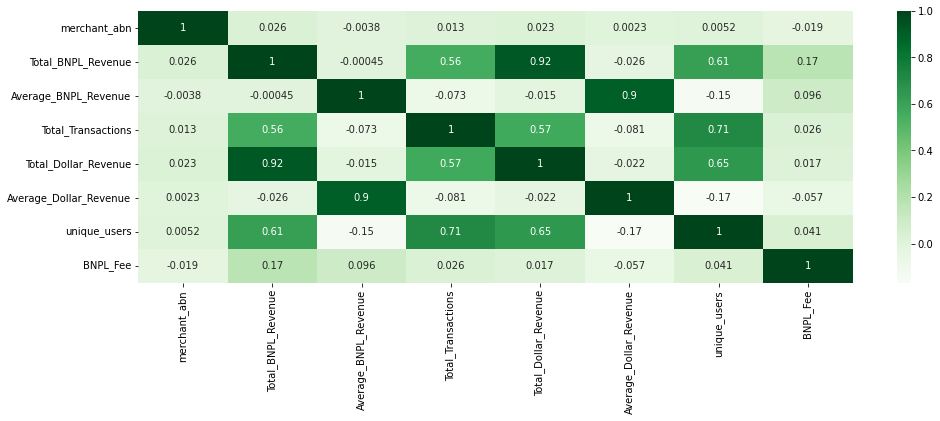

In [32]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)